In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.signal import convolve2d
from scipy.optimize import leastsq

from tqdm import tqdm

from pathlib import Path
BASE = Path('').resolve().parent

DATADIR = BASE / 'data' / 'st001-20230525-test'
assert DATADIR.exists(), f'{DATADIR} not exists!'

In [2]:
bias_fpath_lst = list(DATADIR.glob('st001-bias-20230525-*.fit'))
flat_fpath_lst = list(DATADIR.glob('st001-flat-20230525-*.fit'))
img_fpath_lst = list(DATADIR.glob('st001-M101-20230525-*.fit'))


def gen_shape_mask(fits_lst, target_shape=(6388, 9576), tag=None):
    mask = []
    for idx, fits_path in tqdm(
            enumerate(fits_lst),
            total=len(fits_lst),
            desc=tag,
    ):
        try:
            data = fits.getdata(fits_path)
            if data.shape != target_shape:
                mask.append(False)
            else:
                mask.append(True)
        except:
            mask.append(False)
    return mask


bias_mask = gen_shape_mask(bias_fpath_lst, target_shape=(6388, 9576), tag='bias')
bias_fpath_lst = [bias_fpath_lst[i] for i in range(len(bias_fpath_lst)) if bias_mask[i]]
print(f'bias: {len(bias_fpath_lst):10d}')

flat_mask = gen_shape_mask(flat_fpath_lst, target_shape=(6388, 9576), tag='flat')
flat_fpath_lst = [flat_fpath_lst[i] for i in range(len(flat_fpath_lst)) if flat_mask[i]]
print(f'flat: {len(flat_fpath_lst):10d}')

# img_mask = gen_shape_mask(img_fpath_lst, target_shape=(6388, 9576), tag='image')
# img_fpath_lst = [img_fpath_lst[i] for i in range(len(img_fpath_lst)) if img_mask[i]]
# print(f'img:  {len(img_fpath_lst) :10d}')

bias: 100%|██████████| 20/20 [00:03<00:00,  6.58it/s]


bias:         10


flat: 100%|██████████| 10/10 [00:02<00:00,  3.65it/s]


flat:         10


image: 100%|██████████| 110/110 [00:32<00:00,  3.35it/s]

img:          99


stack bias
- read all bias
- [deleted] validate cosmic ray and remove it (using sigma clip to avoid it)
- stack (median) to get bias on each pixel


In [3]:
assert len(bias_fpath_lst) > 0, 'No bias fits file found!'
bias_lst = []
N_bias_ctr = 0
for bias_fpath in tqdm(
        bias_fpath_lst,
        total=len(bias_fpath_lst),
        desc='reading bias',
):
    try:
        bias_lst.append(fits.getdata(bias_fpath))
        N_bias_ctr += 1
    except:
        continue

# collect to get an 3d array
bias_cube = np.array(bias_lst)
del bias_lst
print(f'bias shape: {bias_cube.shape}')

bias = np.nanmedian(bias_cube, axis=0)  
bias_var = np.nanvar(bias_cube, axis=0) # read noise
del bias_cube
print(f'stacked bias shape: {bias.shape}')

reading bias: 100%|██████████| 10/10 [00:01<00:00,  6.03it/s]


bias shape: (10, 6388, 9576)
stacked bias shape: (6388, 9576)


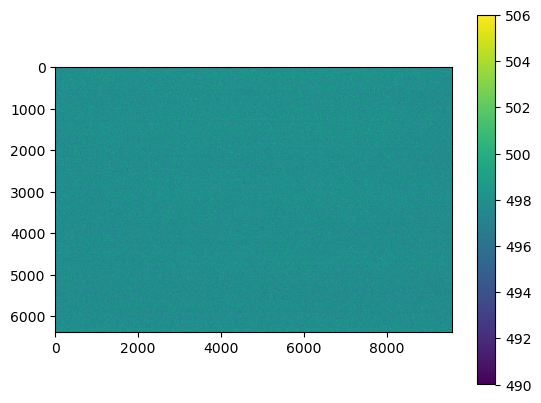

In [4]:
plt.figure()
vmin = np.percentile(bias, 5)
vmax = np.percentile(bias, 95)
plt.imshow(bias, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()
plt.close()

flat - (stacked bias)

In [5]:
flat_lst = []
N_flat_ctr = 0

for flat_fpath in tqdm(
        flat_fpath_lst,
        total=len(flat_fpath_lst),
        desc='reading flat',
):
    try:
        flat_lst.append(fits.getdata(flat_fpath) - bias)
        N_flat_ctr += 1
    except:
        continue

# collect to get an 3d array
flat_cube = np.array(flat_lst)
del flat_lst
print(f'flat shape: {flat_cube.shape}')

reading flat: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


flat shape: (10, 6388, 9576)


计算增益(Gain)

$ADU\sim Poisson(G*N_{e^-})$

对于同一张图片：
- $E(ADU) = G*N_{e^-}$
- $D(ADU) = G^2*N_{e^-}$

In [6]:
# # calculate gain
# def calculate_gain_kernel_single_image(flat, kernel_size: int):
#     assert kernel_size > 1, f'kernel size must be greater than 1'
#     assert kernel_size % 2 == 1, f'kernel size must be odd number, got {kernel_size}'
#     flat_shape = flat.shape
#     min_flat_shape = min(flat_shape)
#     assert kernel_size < min_flat_shape, f'kernel size must be smaller than minimum flat shape {min_flat_shape}'

#     mean_kernel = np.ones_like((kernel_size, kernel_size)) / kernel_size**2
#     # variance_kernel = 
#     kernel_radius = kernel_size // 2
#     cal_shape = (flat_shape[0] // kernel_size, flat_shape[1] // kernel_size)
#     mean_arr = np.empty(cal_shape[0] * cal_shape[1])
#     # mean_mat = np.empty((flat_shape[0] - kernel_size + 1, flat_shape[1] - kernel_size + 1))
#     variance_arr = np.empty_like(mean_arr)
#     # variance_mat = np.empty(mean_mat)
#     for idx in tqdm(
#         range(cal_shape[0] * cal_shape[1]), 
#         desc='calculate gain', 
#         total=cal_shape[0] * cal_shape[1], 
#     ):
#         i = (idx // cal_shape[1]) * kernel_size + kernel_radius + 1
#         j = (idx % cal_shape[1]) * kernel_size + kernel_radius + 1
#         i_min, i_max = i - kernel_radius, i + kernel_radius + 1
#         j_min, j_max = j - kernel_radius, j + kernel_radius + 1
#         mean_arr[idx] = np.nanmean(flat[i_min:i_max, j_min:j_max])
#         variance_arr[idx] = np.nanvar(flat[i_min:i_max, j_min:j_max])
    
#     # plot figure
#     plt.figure()
#     plt.plot(mean_arr, variance_arr, 'k.')
#     plt.xlabel(r'MEAN $K*N_{e^-}$')
#     plt.ylabel(r'VAR $K^2*N_{e^-}$')
#     plt.grid(True)
#     plt.show()
#     plt.close()
#     pass

# calculate_gain_kernel_single_image(flat_cube[0], kernel_size=501)

In [1]:
def cal_gain(flat_cube, bias_var, save_fig=None):
    '''
    return gain, chi2dof
    '''
    flat_mean_arr = np.nanmean(flat_cube, axis=(1, 2))
    flat_var_arr = np.nanvar(flat_cube, axis=(1, 2)) - np.nanmean(bias_var, axis=(0, 1))

    # fit the gain
    def func(x, a):
        return a*x

    def residual(a, x_data, y_data):
        return func(x_data, a) - y_data

    gain_fit_arr, gain_cov = leastsq(residual, x0=1, args=(flat_mean_arr, flat_var_arr))
    gain_fit = gain_fit_arr[0]

    flat_mean_arr_sort_args = np.argsort(flat_mean_arr)
    flat_mean_arr = flat_mean_arr[flat_mean_arr_sort_args]
    flat_var_arr = flat_var_arr[flat_mean_arr_sort_args]

    flat_var_fit = func(flat_mean_arr, gain_fit)

    chi2 = np.sum(np.power(flat_var_arr - flat_var_fit, 2))
    dof = flat_var_fit.shape[0]
    chi2dof = chi2 / dof

    if save_fig:
        plt.figure()
        plt.title('Gain ' + r'$\chi^2 / \rm{DoF}=$' + f'{chi2dof:.3g}')
        plt.plot(flat_mean_arr, flat_var_arr, 'k.', label='data')
        plt.plot(flat_mean_arr, flat_var_fit, 'r--', label=f'gain={gain_fit:.3g}')
        plt.xlabel(r'MEAN $K*N_{e^-}$')
        plt.ylabel(r'VAR $K^2*N_{e^-}$')
        plt.legend()
        plt.grid(True)
        plt.savefig(save_fig, dpi=300)
        plt.close()
    
    return gain_fit, chi2dof


def cal_gain_using_flat(flat_cube: np.ndarray, size_subimg: int, save_perfix: str=''):
    N_flat, w_flat, h_flat = flat_cube.shape
    size_subimg = 10
    flat_stat_dict = {
        'w_st': [], 
        'w_ed': [], 
        'h_st': [], 
        'h_ed': [], 
        'gain': [], 
        'chi2dof': [],
    }
    img_save_dir = BASE / 'figure' / 'gain'
    img_save_dir.mkdir(exist_ok=True, parents=True)
    data_save_dir = BASE / 'my_data' / 'gain'
    data_save_dir.mkdir(exist_ok=True, parents=True)
    N_cal_w = w_flat // size_subimg
    N_cal_h = h_flat // size_subimg
    N_cal_total = N_cal_w * N_cal_h
    for idx in tqdm(
        range(N_cal_total), 
        desc='cal gain', 
        total=N_cal_total,
    ):
        i = idx // N_cal_h
        j = idx % N_cal_h
        i_st, i_ed = i*size_subimg, (i+1)*size_subimg
        j_st, j_ed = j*size_subimg, (j+1)*size_subimg
        save_path = img_save_dir / f'{save_perfix}{i_st:04d}_{i_ed:04d}_{j_st:04d}_{j_ed:04d}.png'
        gain_fit, chi2dof = cal_gain(flat_cube[:, i_st:i_ed, j_st:j_ed], bias_var[i_st:i_ed, j_st:j_ed], save_fig=save_path)
        flat_stat_dict['w_st'].append(i_st)
        flat_stat_dict['w_ed'].append(i_ed)
        flat_stat_dict['h_st'].append(j_st)
        flat_stat_dict['h_ed'].append(j_ed)
        flat_stat_dict['gain'].append(gain_fit)
        flat_stat_dict['chi2dof'].append(chi2dof)

    df_gain = pd.DataFrame(flat_stat_dict)
    df_gain.to_csv(data_save_dir / f'{save_perfix}{i_st:04d}_{i_ed:04d}_{j_st:04d}_{j_ed:04d}.csv', index=False)

NameError: name 'np' is not defined

In [3]:
import matplotlib.pyplot as plt

plt.imshow(flat_cube[0, :, :])
plt.show()
plt.close()

NameError: name 'flat_cube' is not defined